In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud
import pandas_profiling
import missingno as msno
import datetime
import re
pd.set_option('display.width',200)
pd.set_option('display.max_colwidth',100)

## This file helps you plot more efficiently
feel free to contact me(yl3963@columbia.edu) if you have any questions


## prepare dataset

In [2]:
twitter2 = pd.read_csv("trayvontweets/Trayvon Tweets 2013.csv",encoding = "latin1", index_col = 0)

/Users/ycr/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ycr/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
twitter2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 20 columns):
id                      1048575 non-null int64
message_id              1048575 non-null int64
user_handle             1048575 non-null object
orig_user_id            1048575 non-null int64
orig_user_handle        1048574 non-null object
topsy_type              1048575 non-null object
orig_date_posted_gmt    1048575 non-null float64
date_posted_gmt         1048575 non-null float64
message                 1046510 non-null object
orig_user_location      1048575 non-null object
coordinates             20954 non-null object
tweet_location          25439 non-null object
longitude               20954 non-null float64
latitude                20954 non-null float64
created_at_gmt          229732 non-null float64
seconds_after_event     1048575 non-null int64
FIPS                    1048575 non-null object
County                  1048569 non-null object
City                    1041990

In [4]:
data_msg_time = twitter2.loc[twitter2['message'].isnull() == False,['date_posted_gmt','message']]

In [5]:
data_msg_time = data_msg_time.sample(n = 100000)
data_msg_time = data_msg_time.reset_index(drop = True)

In [6]:
def date(dates):
    delta=datetime.timedelta(days=dates)
    today=datetime.datetime.strptime('1899-12-30 00:00:00','%Y-%m-%d %H:%M:%S')+delta
    return datetime.datetime.strftime(today,'%Y-%m-%d %H:%M:%S')

In [7]:
data_msg_time['date_posted_gmt'] = data_msg_time['date_posted_gmt'].apply(lambda x: date(x))

In [8]:
data_msg_time.head()

,date_posted_gmt,message
0,2013-07-15 13:52:39,David Simon wrote an explosive blog post about Trayvon Martin and is responding to every comment...
1,2013-08-03 22:25:12,"""@SomeRecklessKid: People Wont Never Just Let Trayvon Martin Rest"""
2,2013-07-10 23:56:16,#Zimmerman RT @DavidLimbaugh: Did the state hide or destroy evidence? My gosh this gets creepier...
3,2013-07-12 05:01:35,Blk out for Trayvon Martin ä_
4,2013-07-20 20:23:50,Why Is the Government So Involved in the Trayvon / Zimmerman Case? http://t.co/JVF4pQndf1


### read emojis
########################
TODO 

###  function add_ymdw: add year month day  week columns for original dataframe 


In [9]:
def add_ymdw(df):
    df['date']=pd.to_datetime(df['date_posted_gmt'])

    df['year']=df['date'].apply(lambda x: x.year)

    df['month']=df['date'].apply(lambda x: x.month)

    df['day']=df['date'].apply(lambda x: x.day)
    
    def getweek(a,b,c):
        return datetime.date(a,b,c).isocalendar()[1]
    df['week'] = df.apply(lambda x: getweek(x['year'], x['month'],x['day']), axis=1)

    return df

In [10]:
data_msg_time=add_ymdw(data_msg_time)

### split dataset according to their year
you can get 3 dataframes finally

In [11]:
def split_year(df):
    df2012=df[df['year']==2012]
    df2013=df[df['year']==2013]
    df2014=df[df['year']==2014]
    return df2012,df2013,df2014

In [12]:
data_msg_time2012,data_msg_time2013,data_msg_time2014=split_year(data_msg_time)
data_msg_time2013.head()

,date_posted_gmt,message,date,year,month,day,week
0,2013-07-15 13:52:39,David Simon wrote an explosive blog post about Trayvon Martin and is responding to every comment...,2013-07-15 13:52:39,2013,7,15,29
1,2013-08-03 22:25:12,"""@SomeRecklessKid: People Wont Never Just Let Trayvon Martin Rest""",2013-08-03 22:25:12,2013,8,3,31
2,2013-07-10 23:56:16,#Zimmerman RT @DavidLimbaugh: Did the state hide or destroy evidence? My gosh this gets creepier...,2013-07-10 23:56:16,2013,7,10,28
3,2013-07-12 05:01:35,Blk out for Trayvon Martin ä_,2013-07-12 05:01:35,2013,7,12,28
4,2013-07-20 20:23:50,Why Is the Government So Involved in the Trayvon / Zimmerman Case? http://t.co/JVF4pQndf1,2013-07-20 20:23:50,2013,7,20,29


### preprocess message

In [13]:
#change all to lower case for future regex
data_msg_time2013['message'] = data_msg_time2013['message'].str.lower()

/Users/ycr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## detect emotions

### import LIWC dictionary

In [54]:
file = open("LIWC Dictionary/LIWC_dic.txt","r")

LIWC = file.readlines()
LIWC_dict = {}
for line in LIWC:
    line = line.split(',')
    category = line[0]
    words = line[1:]
    words[0] = words[0][1:]
    words[-1] = words[-1][:-2]
    LIWC_dict[category] = words

In [55]:
LIWC_dict.keys()

dict_keys(['Function', 'Pronoun', 'Ppron', 'I', 'We', 'You', 'SheHe', 'They', 'Ipron', 'Article', 'Prep', 'Auxverb', 'Adverb', 'Conj', 'Negate', 'Verb', 'Adj', 'Compare', 'Interrog', 'Number', 'Quant', 'Affect', 'Posemo', 'Negemo', 'Anx', 'Anger', 'Sad', 'Social', 'Family', 'Friend', 'Female', 'Male', 'CogProc', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain', 'Differ', 'Percept', 'See', 'Hear', 'Feel', 'Bio', 'Body', 'Health', 'Sexual', 'Ingest', 'Drives', 'Affiliation', 'Achieve', 'Power', 'Reward', 'Risk', 'FocusPast', 'FocusPresent', 'FocusFuture', 'Relativ', 'Motion', 'Space', 'Time', 'Work', 'Leisure', 'Home', 'Money', 'Relig', 'Death', 'Informal', 'Swear', 'Netspeak', 'Assent', 'Nonflu', 'Filler', 'Stress'])

### Adjust LIWC dictionary

In [56]:
posemo = LIWC_dict['Posemo']
for i in range(len(posemo)):
    if posemo[i][-1] == '*':
        posemo[i] = r'\b' + posemo[i][:-1]
    else:
        posemo[i] = r'\b' + posemo[i] + r'\b'
posemo[0] = '\(:'
posemo[5] = ':\)'
reg_posemo = "|".join(posemo)
reg_posemo = re.compile(reg_posemo)

In [58]:
negemo = LIWC_dict['Negemo']
for i in range(len(negemo)):
    if negemo[i][-1] == '*':
        negemo[i] = r'\b' + negemo[i][:-1]
    else:
        negemo[i] = r'\b' + negemo[i] + r'\b'
negemo[0] = '\):'
negemo[5] = ':\('
reg_negemo = "|".join(negemo)
reg_negemo = re.compile(reg_negemo)

In [59]:
anx = LIWC_dict['Anx']
for i in range(len(anx)):
    if anx[i][-1] == '*':
        anx[i] = r'\b' + anx[i][:-1]
    else:
        anx[i] = r'\b' + anx[i] + r'\b'
reg_anx = "|".join(anx)
reg_anx = re.compile(reg_anx)

In [60]:
anger = LIWC_dict['Anger']
for i in range(len(anger)):
    if anger[i][-1] == '*':
        anger[i] = r'\b' + anger[i][:-1]
    else:
        anger[i] = r'\b' + anger[i] + r'\b'
reg_anger = "|".join(anger)
reg_anger = re.compile(reg_anger)

In [61]:
sad = LIWC_dict['Sad']
for i in range(len(sad)):
    if sad[i][-1] == '*':
        sad[i] = r'\b' + sad[i][:-1]
    else:
        sad[i] = r'\b' + sad[i] + r'\b'
reg_sad = "|".join(sad)
reg_sad = re.compile(reg_sad)

In [62]:
stress = LIWC_dict['Stress']
for i in range(len(stress)):
    if stress[i][-1] == '*':
        stress[i] = r'\b' + stress[i][:-1]
    else:
        stress[i] = r'\b' + stress[i] + r'\b'
reg_stress = "|".join(stress)
reg_stress = re.compile(reg_stress)

In [65]:
reg_posemo.search("humorabc")

<re.Match object; span=(0, 5), match='humor'>

In [66]:
reg_posemo.search("happyhhh")

### function to check whether the message contains the category or not

In [85]:
def check_category(s,category,dic):
    '''
    s type: string
    category type: list of string 
    '''
    if category == 'Posemo':
        if reg_posemo.search(s):
            return category
    elif category == 'Negemo':
        if reg_negemo.search(s):
            return category
    elif category == 'Anx':
        if reg_anx.search(s):
            return category
    elif category == 'Anger':
        if reg_anger.search(s):
            return category
    elif category == 'Sad':
        if reg_sad.search(s):
            return category
    elif category == 'Stress':
        if reg_stress.search(s):
            return category
    else:
        print("only valid for six category")
    return 'NA'

In [86]:
check_category('stressed','Anx',LIWC_dict)

'Anx'

In [87]:
check_category('happy!!!','Anx',LIWC_dict)

'NA'

In [88]:
check_category('afraid','Negemo',LIWC_dict)

'Negemo'

In [89]:
check_category('confu','Negemo',LIWC_dict)

'NA'

### add_tag_col
- df:  dataframe 
- cate: list of emotion category
- dic: the dictionary stores all words belong to the category
e.g. here tag='Anx' means the message of the row contains anxiety words

In [90]:
def add_tag_col(df,cate,dic):
    for category in cate:
        df[category]=df.apply(lambda x: check_category(x['message'],category,dic),axis=1)
    return df

In [91]:
data_msg_time2013.head()

,date_posted_gmt,message,date,year,month,day,week,Sad,Anx,Anger,Negemo
0,2013-07-15 13:52:39,david simon wrote an explosive blog post about trayvon martin and is responding to every comment...,2013-07-15 13:52:39,2013,7,15,29,NA,NA,NA,NA
1,2013-08-03 22:25:12,"""@somerecklesskid: people wont never just let trayvon martin rest""",2013-08-03 22:25:12,2013,8,3,31,NA,NA,NA,NA
2,2013-07-10 23:56:16,#zimmerman rt @davidlimbaugh: did the state hide or destroy evidence? my gosh this gets creepier...,2013-07-10 23:56:16,2013,7,10,28,NA,NA,NA,Negemo
3,2013-07-12 05:01:35,blk out for trayvon martin ä_,2013-07-12 05:01:35,2013,7,12,28,NA,NA,NA,NA
4,2013-07-20 20:23:50,why is the government so involved in the trayvon / zimmerman case? http://t.co/jvf4pqndf1,2013-07-20 20:23:50,2013,7,20,29,NA,NA,NA,NA


In [92]:
emotions = ['Sad','Anx','Anger','Negemo','Posemo','Stress']
data_msg_time2013=add_tag_col(data_msg_time2013,emotions,LIWC_dict)  
data_msg_time2013.head()

/Users/ycr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date_posted_gmt,message,date,year,month,day,week,Sad,Anx,Anger,Negemo,Posemo,Stress
0,2013-07-15 13:52:39,david simon wrote an explosive blog post about trayvon martin and is responding to every comment...,2013-07-15 13:52:39,2013,7,15,29,NA,NA,NA,NA,NA,NA
1,2013-08-03 22:25:12,"""@somerecklesskid: people wont never just let trayvon martin rest""",2013-08-03 22:25:12,2013,8,3,31,NA,NA,NA,NA,NA,NA
2,2013-07-10 23:56:16,#zimmerman rt @davidlimbaugh: did the state hide or destroy evidence? my gosh this gets creepier...,2013-07-10 23:56:16,2013,7,10,28,NA,NA,Anger,Negemo,NA,NA
3,2013-07-12 05:01:35,blk out for trayvon martin ä_,2013-07-12 05:01:35,2013,7,12,28,NA,NA,NA,NA,NA,NA
4,2013-07-20 20:23:50,why is the government so involved in the trayvon / zimmerman case? http://t.co/jvf4pqndf1,2013-07-20 20:23:50,2013,7,20,29,NA,NA,NA,NA,NA,NA


## Plot emotions in 2013

In [93]:
df_all_week = data_msg_time2013.groupby('week')['message'].count()
df_all_week

week
1       102
28    30124
29    31943
30     7412
31     2305
32     1337
33      877
34     1241
35      950
36      829
37     1298
38      290
39      451
40      333
41      317
42      198
43      301
44      713
45      334
46      299
47     2091
48      509
49      333
50      524
51      537
52      276
Name: message, dtype: int64

Most of the data are from week28. So we will plot from week 28.

### plot_count_trend function
- df: the dataframe contains at least **message,week, tag** cols

- cate: the category of emotion e.g. anxiety='anx

In [94]:
def plot_count_trend(df,category):
    df_category_week = pd.DataFrame()
    for cate in category:
        df_cate_week=df[df[cate]==cate].groupby('week')['message'].count()    
        df_cate_week = pd.DataFrame(df_cate_week)
        df_cate_week.columns = [cate]
        df_category_week = pd.concat([df_category_week,df_cate_week],axis = 1)
    plt.figure(figsize=(20,8))
    plt.xlabel('week in 2013',size=20)
    plt.ylabel('tweet num',size=20)
    # gca stands for 'get current axis'
    ax = plt.gca()
    df_category_week.plot(kind='line',ax=ax,fontsize=20)
    return df_category_week

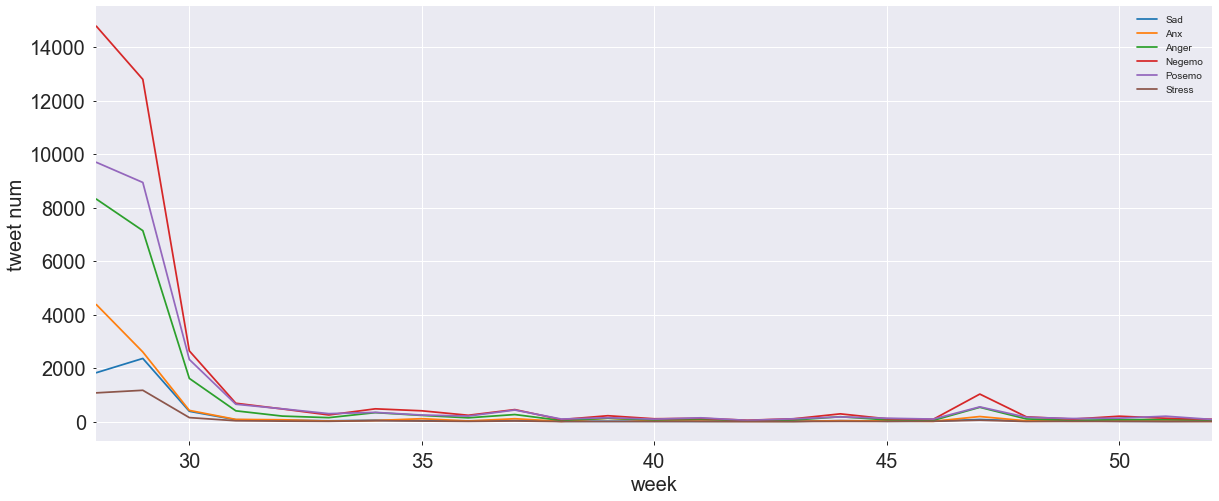

In [95]:
df_cate_week = plot_count_trend(data_msg_time2013.loc[data_msg_time2013['week']>=28],emotions)

### plot_fraction_trend
- df: the dataframe contains at least **message,week,tag cols**
- cate: the category of emotion e.g. anxiety='anx
- title: graph title
- xlabel: graph xlabel

In [96]:
df_cate_week = pd.concat([df_cate_week,df_all_week[df_all_week.index>=28]],axis = 1)

In [97]:
for cate in  emotions:
    df_cate_week[cate] = df_cate_week[cate]/df_cate_week['message']*100
df_cate_week = df_cate_week.drop(columns='message')

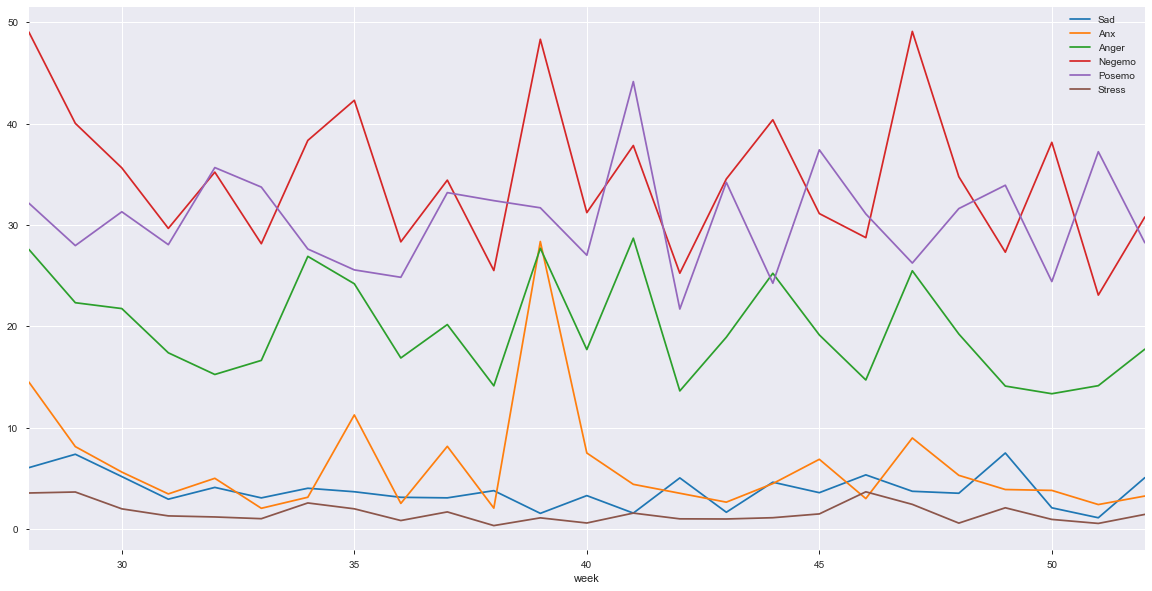

In [99]:
df_cate_week.plot(figsize=(20,10))

In [100]:
df_cate_week.corr()

,Sad,Anx,Anger,Negemo,Posemo,Stress
Sad,1.000000,-0.076775,-0.040947,0.024383,-0.268979,0.631777
Anx,-0.076775,1.000000,0.575232,0.698836,-0.008894,0.192143
Anger,-0.040947,0.575232,1.000000,0.822535,0.088731,0.395292
Negemo,0.024383,0.698836,0.822535,1.000000,-0.124356,0.435650
Posemo,-0.268979,-0.008894,0.088731,-0.124356,1.000000,-0.035502
Stress,0.631777,0.192143,0.395292,0.435650,-0.035502,1.000000


## Plot emotions in week 28 - week 40

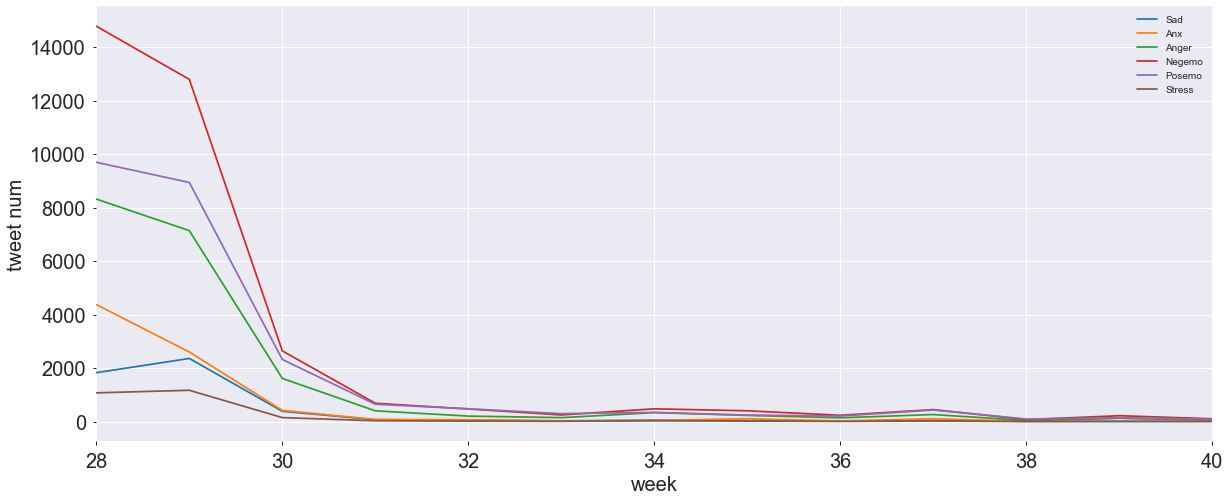

In [120]:
df_cate_week_narrow = plot_count_trend(data_msg_time2013.loc[(data_msg_time2013['week']>=28)& (data_msg_time2013['week']<=40)],emotions)


In [121]:
df_cate_week_narrow = pd.concat([df_cate_week_narrow,df_all_week[(df_all_week.index>=28) & (df_all_week.index<=40)]],axis = 1)
for cate in  emotions:
    df_cate_week_narrow[cate] = df_cate_week_narrow[cate]/df_cate_week_narrow['message']*100
df_cate_week_narrow = df_cate_week_narrow.drop(columns='message')

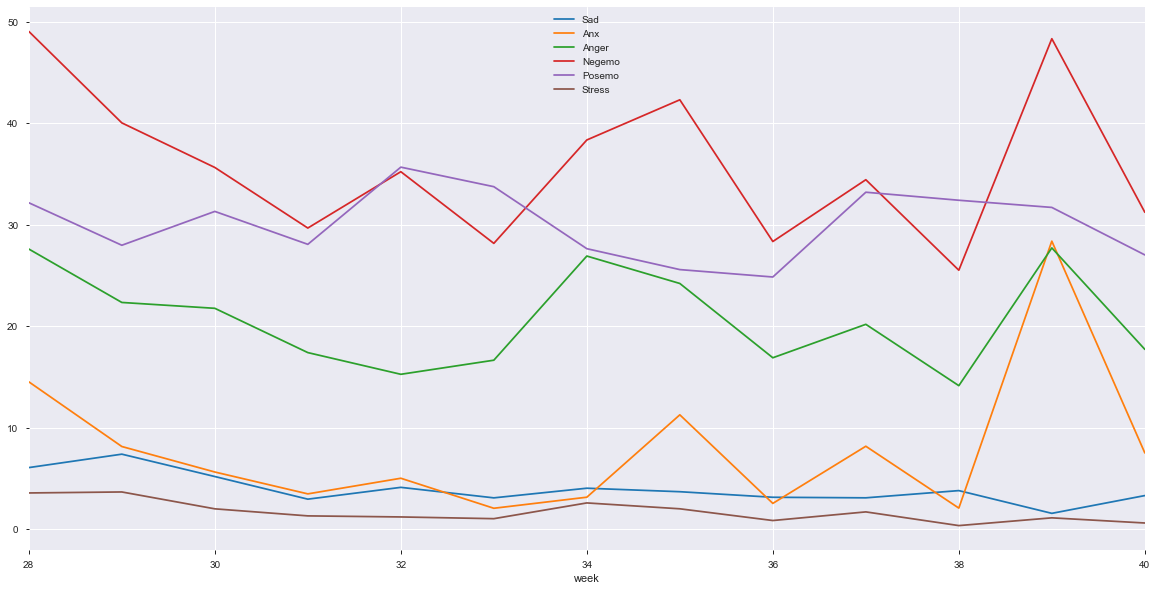

In [122]:
df_cate_week_narrow.plot(figsize=(20,10))

In [123]:
df_cate_week_narrow.corr()

,Sad,Anx,Anger,Negemo,Posemo,Stress
Sad,1.000000,-0.183779,0.192882,0.259161,-0.021298,0.787635
Anx,-0.183779,1.000000,0.681739,0.812065,0.094799,0.185383
Anger,0.192882,0.681739,1.000000,0.900312,-0.172416,0.678294
Negemo,0.259161,0.812065,0.900312,1.000000,0.029602,0.663371
Posemo,-0.021298,0.094799,-0.172416,0.029602,1.000000,-0.096529
Stress,0.787635,0.185383,0.678294,0.663371,-0.096529,1.000000
